# Deep Learnign Final Project: Image Classification with PyTorch
## Part 2: Transfer learning

## PARAGRAPH

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import os
import torch.nn.functional as F

# Configuration
DATA_PATH = 'data' 
BATCH_SIZE = 32
IMG_SIZE = 300    
VALID_SPLIT = 0.2
SEED = 42
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Transforms for dataset
data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(NORM_MEAN, NORM_STD)
])

# Load dataset
try:
    full_dataset = datasets.ImageFolder(root=DATA_PATH, transform=data_transforms)
    class_names = full_dataset.classes
    
    # Split
    val_size = int(len(full_dataset) * VALID_SPLIT)
    train_size = len(full_dataset) - val_size
    generator = torch.Generator().manual_seed(SEED)
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

    # Loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    
    print(f"Custom Data Loaded: {len(train_dataset)} training images.")
except:
    print("Warning: Could not load custom data yet. Make sure 'data' folder exists.")

Custom Data Loaded: 268 training images.


In [4]:
class DeepCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(DeepCNN, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        # Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        # Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        # Block 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.gap(x)
        x = x.flatten(1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
import torchvision
from torchvision import datasets
import torch.nn.functional as F

# 1. Configuration for CIFAR
print(f"Goal: Pre-train DeepCNN on 60,000 CIFAR images to learn features.")

# CIFAR-10 stats
CIFAR_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR_STD = [0.2023, 0.1994, 0.2010]

# Simple transforms for CIFAR (32x32 is native size)
cifar_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

Download and train CIFAR10

In [ ]:
# 2. Download and Load CIFAR-10
print("Downloading CIFAR-10...")
# We use a batch size of 64 for faster training on the larger dataset
cifar_train = datasets.CIFAR10(root='./data_cifar', train=True, download=True, transform=cifar_transforms)
cifar_loader = DataLoader(cifar_train, batch_size=64, shuffle=True, num_workers=2)

# 3. Define the Model (Output = 10 classes)
class DeepCNN_CIFAR(nn.Module):
    def __init__(self):
        super(DeepCNN_CIFAR, self).__init__()
        # EXACT SAME BODY as your Bathroom model
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        
        # 10 classes for CIFAR (Plane, Car, Bird, etc.)
        self.fc = nn.Linear(256, 10) 

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.gap(x)
        x = x.flatten(1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# 4. Train on CIFAR (The "Pre-training")
# We train for 10 epochs. We don't need a validation graph here, 
# we just need the model to learn what a "circle" and a "line" are.
print("\nTraining DeepCNN on CIFAR-10 (10 Epochs)...")
model_cifar = DeepCNN_CIFAR().to(device)
optimizer_cifar = optim.Adam(model_cifar.parameters(), lr=0.001)
criterion_cifar = nn.CrossEntropyLoss()

model_cifar.train()
for epoch in range(10): 
    running_loss = 0.0
    for inputs, labels in cifar_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_cifar.zero_grad()
        outputs = model_cifar(inputs)
        loss = criterion_cifar(outputs, labels)
        loss.backward()
        optimizer_cifar.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/10 - Loss: {running_loss/len(cifar_loader):.4f}")

# 5. Save the CIFAR Weights
torch.save(model_cifar.state_dict(), 'deep_cnn_cifar_pretrained.pth')
print("Pre-trained CIFAR model saved!")

In [8]:
# Same utility function from part 1
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                # Deep copy the model if it's the best one so far
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [14]:
# 1. Define the architecture (Must match the saved CIFAR model structure initially)
class DeepCNN_Transfer(nn.Module):
    def __init__(self):
        super(DeepCNN_Transfer, self).__init__()
        # EXACT SAME BODY
        # Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Block 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Head
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)  # Drop 50% of neurons
        
        # INITIAL HEAD: 10 classes
        self.fc = nn.Linear(256, 10) 

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.gap(x)
        x = x.flatten(1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# 2. Instantiate and Load Weights
print("Loading Pre-trained CIFAR 'Brain'...")
model_transfer = DeepCNN_Transfer().to(device)
model_transfer.load_state_dict(torch.load('deep_cnn_cifar_pretrained.pth'))
print("Weights Loaded!")

# 3. FREEZE the Body
# We turn off gradient calculation for all existing parameters
for param in model_transfer.parameters():
    param.requires_grad = False

print("Convolutional Layers Frozen (We won't retrain them).")

# 4. Replace the Head
# Since we are assigning a NEW layer, its 'requires_grad' will default to True (Trainable)
num_ftrs = model_transfer.fc.in_features  # Should be 256
model_transfer.fc = nn.Linear(num_ftrs, 3) # NEW Head: our 3 Classes
model_transfer = model_transfer.to(device)

print("New Head Attached (Output: 3 Classes). Ready for Fine-Tuning.")

# 5. Fine-Tune on our Dataset
# Note: We only optimize the parameters that require gradients (the new head)
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_transfer.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("\nStarting Transfer Learning (Fine-Tuning)...")
# We use our original train_loader (from the bathroom dataset)
# Training for 15 epochs should be plenty since the body is already smart
model_transfer, hist_transfer = train_model(model_transfer, criterion, optimizer_ft, num_epochs=15)

torch.save(model_transfer.state_dict(), 'deep_cnn_transfer_learning.pth')

Loading Pre-trained CIFAR 'Brain'...
Weights Loaded!
Convolutional Layers Frozen (We won't retrain them).
New Head Attached (Output: 3 Classes). Ready for Fine-Tuning.

Starting Transfer Learning (Fine-Tuning)...
Epoch 1/15
----------


C:\Users\Dmytro\AppData\Local\Temp\ipykernel_17840\3481211753.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_transfer.load_state_dict(torch.load('deep_cnn_cifar_

train Loss: 1.1172 Acc: 0.3619
val Loss: 1.0727 Acc: 0.3333
Epoch 2/15
----------
train Loss: 1.0767 Acc: 0.4067
val Loss: 1.0559 Acc: 0.4091
Epoch 3/15
----------
train Loss: 1.0509 Acc: 0.4328
val Loss: 1.0445 Acc: 0.4091
Epoch 4/15
----------
train Loss: 1.0470 Acc: 0.4552
val Loss: 1.0301 Acc: 0.5152
Epoch 5/15
----------
train Loss: 1.0448 Acc: 0.4403
val Loss: 1.0215 Acc: 0.4848
Epoch 6/15
----------
train Loss: 1.0182 Acc: 0.5037
val Loss: 1.0109 Acc: 0.5152
Epoch 7/15
----------
train Loss: 0.9670 Acc: 0.5672
val Loss: 1.0028 Acc: 0.5303
Epoch 8/15
----------
train Loss: 0.9927 Acc: 0.4851
val Loss: 0.9914 Acc: 0.5000
Epoch 9/15
----------
train Loss: 0.9940 Acc: 0.5299
val Loss: 0.9853 Acc: 0.5152
Epoch 10/15
----------
train Loss: 1.0006 Acc: 0.4627
val Loss: 0.9844 Acc: 0.5303
Epoch 11/15
----------
train Loss: 0.9924 Acc: 0.4851
val Loss: 0.9735 Acc: 0.5303
Epoch 12/15
----------
train Loss: 0.9359 Acc: 0.5709
val Loss: 0.9688 Acc: 0.5455
Epoch 13/15
----------
train Loss: 

In [38]:
def plot_transfer_results(history, title, baseline=0.63):
    """
    Function to plot training history against a baseline.
    Args:
        history: The history dictionary from train_model (contains 'train_acc', 'val_acc', etc.)
        title: String to add to the graph title
        baseline: The accuracy of your best Part 1 model
    """
    plt.figure(figsize=(12, 5))

    # --- Plot Accuracy ---
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    # Add the Red Baseline Line
    plt.axhline(y=baseline, color='r', linestyle='--', label=f'Baseline (Scratch): {baseline}')
    plt.title(f'Accuracy: {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # --- Plot Loss ---
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'Loss: {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

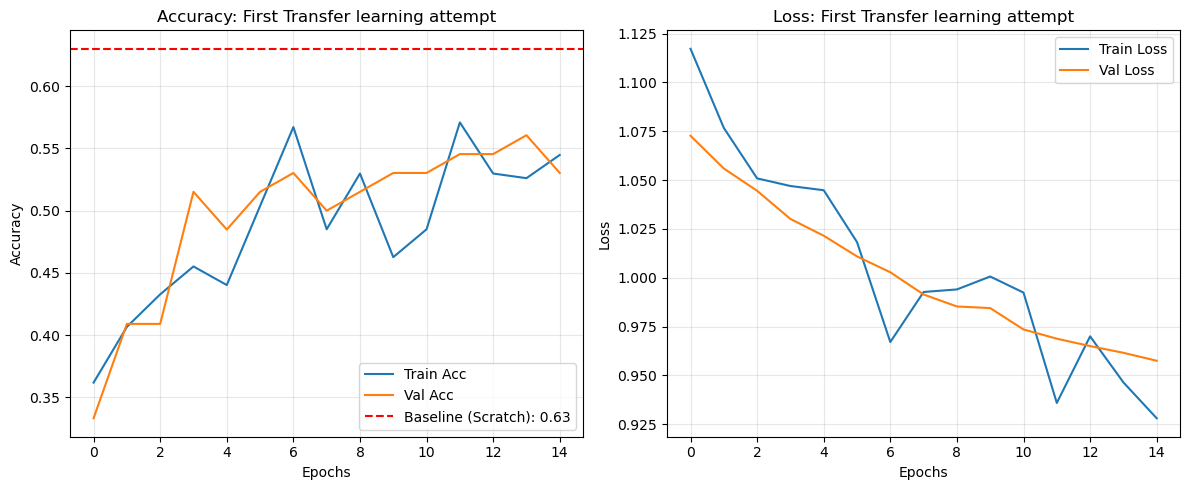

In [44]:
plot_transfer_results(hist_transfer, "First Transfer learning attempt")

In [16]:
import torch.optim as optim

print("Unfreezing the last convolutional block for Fine-Tuning...")

# 1. Unfreeze the last block (Conv4 + BN4)
# We want the model to adjust its high-level features to the new image size
for param in model_transfer.conv4.parameters():
    param.requires_grad = True
for param in model_transfer.bn4.parameters():
    param.requires_grad = True

# 2. Lower the Learning Rate significantly (CRITICAL STEP)
# We use 1e-4 (10x smaller than before) because we don't want to
# destroy the delicate pre-trained weights; we just want to nudge them.
optimizer_finetune = optim.Adam(filter(lambda p: p.requires_grad, model_transfer.parameters()), lr=1e-4)

print("Restarting Training (Fine-Tuning Last Block)...")

# 3. Train for another 15 epochs
# Note: We pass the SAME model instance, so it starts from ~55% accuracy, not 0%
model_transfer, hist_finetune = train_model(model_transfer, criterion, optimizer_finetune, num_epochs=15)

# 4. Save this 'Fine-Tuned' version
torch.save(model_transfer.state_dict(), 'deep_cnn_finetuned.pth')
print("Fine-Tuned Model Saved!")

Unfreezing the last convolutional block for Fine-Tuning...
Restarting Training (Fine-Tuning Last Block)...
Epoch 1/15
----------
train Loss: 0.9327 Acc: 0.5858
val Loss: 0.9635 Acc: 0.5758
Epoch 2/15
----------
train Loss: 0.9119 Acc: 0.6269
val Loss: 0.9616 Acc: 0.5758
Epoch 3/15
----------
train Loss: 0.8827 Acc: 0.6119
val Loss: 0.9603 Acc: 0.5758
Epoch 4/15
----------
train Loss: 0.9116 Acc: 0.5522
val Loss: 0.9574 Acc: 0.5758
Epoch 5/15
----------
train Loss: 0.9201 Acc: 0.5522
val Loss: 0.9545 Acc: 0.5758
Epoch 6/15
----------
train Loss: 0.8995 Acc: 0.5784
val Loss: 0.9422 Acc: 0.6061
Epoch 7/15
----------
train Loss: 0.8997 Acc: 0.5746
val Loss: 0.9436 Acc: 0.6061
Epoch 8/15
----------
train Loss: 0.8782 Acc: 0.5784
val Loss: 0.9365 Acc: 0.6061
Epoch 9/15
----------
train Loss: 0.9395 Acc: 0.5672
val Loss: 0.9306 Acc: 0.6212
Epoch 10/15
----------
train Loss: 0.8864 Acc: 0.5896
val Loss: 0.9300 Acc: 0.6212
Epoch 11/15
----------
train Loss: 0.8810 Acc: 0.5634
val Loss: 0.9244 A

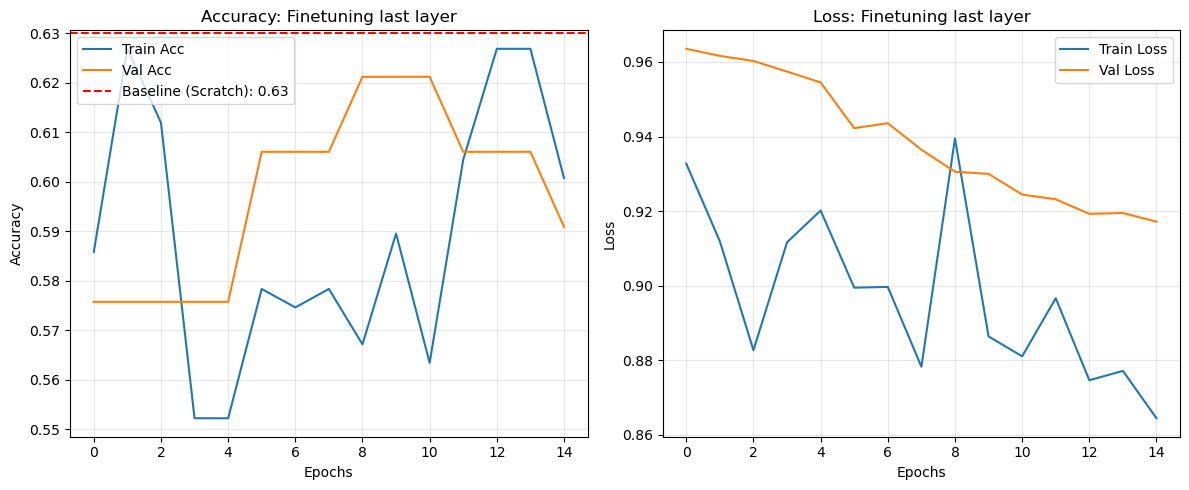

In [46]:
plot_transfer_results(hist_finetune, "Finetuning last layer")

As we see the models failed to achieve good accuracy, or even to surpass our base model's results. A suspected problem can be that CIFAR10 consists of 32x32 and our body is trained on them, but our bathroom data is squezed to 300x300 pixels. Lets squeze them to 32 by 32 to match the CIFAR dataset. 

In [27]:
# --- CRITICAL CHANGE: Resize to 32x32 to match CIFAR ---
IMG_SIZE_CIFAR = 32 

print(f"Reloading Dataset resized to {IMG_SIZE_CIFAR}x{IMG_SIZE_CIFAR}...")

# Defines transforms with the NEW size
cifar_compatible_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE_CIFAR, IMG_SIZE_CIFAR)),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD) # Use CIFAR stats now!
])

# Load the dataset with these new transforms
try:
    full_dataset_32 = datasets.ImageFolder(root=DATA_PATH, transform=cifar_compatible_transforms)
    
    # Split again
    val_size = int(len(full_dataset_32) * VALID_SPLIT)
    train_size = len(full_dataset_32) - val_size
    generator = torch.Generator().manual_seed(SEED)
    train_dataset_32, val_dataset_32 = random_split(full_dataset_32, [train_size, val_size], generator=generator)

    # New Loaders
    train_loader_32 = DataLoader(train_dataset_32, batch_size=32, shuffle=True, num_workers=0)
    val_loader_32 = DataLoader(val_dataset_32, batch_size=32, shuffle=False, num_workers=0)
    
    print(f"Data Reloaded! Images are now 32x32 pixels.")
except:
    print("Error loading data. Check path.")

Reloading Dataset resized to 32x32...
Data Reloaded! Images are now 32x32 pixels.


In [29]:
# 1. Load the Pre-trained CIFAR Model
print("Loading Pre-trained CIFAR Model...")
model_transfer_32 = DeepCNN_Transfer().to(device)
model_transfer_32.load_state_dict(torch.load('deep_cnn_cifar_pretrained.pth'))

# 2. Freeze the Body
for param in model_transfer_32.parameters():
    param.requires_grad = False

# 3. Replace Head (10 -> 3 classes)
num_ftrs = model_transfer_32.fc.in_features
model_transfer_32.fc = nn.Linear(num_ftrs, 3).to(device)

# 4. Train (using the NEW 32x32 loaders)
print("Starting Transfer Learning on 32x32 Images...")
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_transfer_32.fc.parameters(), lr=0.001)

# Pass the NEW loaders explicitly by temporarily swapping variables 
temp_train = train_loader
temp_val = val_loader
train_loader = train_loader_32
val_loader = val_loader_32

model_transfer_32, hist_transfer_32 = train_model(model_transfer_32, criterion, optimizer_ft, num_epochs=15)

# Swap back just in case
train_loader = temp_train
val_loader = temp_val

🔄 Loading Pre-trained CIFAR Model...
🚀 Starting Transfer Learning on 32x32 Images...
Epoch 1/15
----------


C:\Users\Dmytro\AppData\Local\Temp\ipykernel_17840\3682707410.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_transfer_32.load_state_dict(torch.load('deep_cnn_cifa

train Loss: 1.1361 Acc: 0.3918
val Loss: 1.0905 Acc: 0.4091
Epoch 2/15
----------
train Loss: 1.1169 Acc: 0.4104
val Loss: 1.0659 Acc: 0.3788
Epoch 3/15
----------
train Loss: 1.0916 Acc: 0.3881
val Loss: 1.0332 Acc: 0.4545
Epoch 4/15
----------
train Loss: 1.0246 Acc: 0.5149
val Loss: 1.0272 Acc: 0.4394
Epoch 5/15
----------
train Loss: 1.0127 Acc: 0.5075
val Loss: 0.9881 Acc: 0.4848
Epoch 6/15
----------
train Loss: 0.9710 Acc: 0.5634
val Loss: 0.9720 Acc: 0.5303
Epoch 7/15
----------
train Loss: 0.9319 Acc: 0.5634
val Loss: 0.9574 Acc: 0.5303
Epoch 8/15
----------
train Loss: 0.9489 Acc: 0.5485
val Loss: 0.9505 Acc: 0.5152
Epoch 9/15
----------
train Loss: 0.9440 Acc: 0.5784
val Loss: 0.9292 Acc: 0.5455
Epoch 10/15
----------
train Loss: 0.9299 Acc: 0.5336
val Loss: 0.9420 Acc: 0.5909
Epoch 11/15
----------
train Loss: 0.9119 Acc: 0.5672
val Loss: 0.9285 Acc: 0.5606
Epoch 12/15
----------
train Loss: 0.9423 Acc: 0.5187
val Loss: 0.9173 Acc: 0.6061
Epoch 13/15
----------
train Loss: 

Graph 1: Transfer Learning (Frozen Body) on 32x32 Images


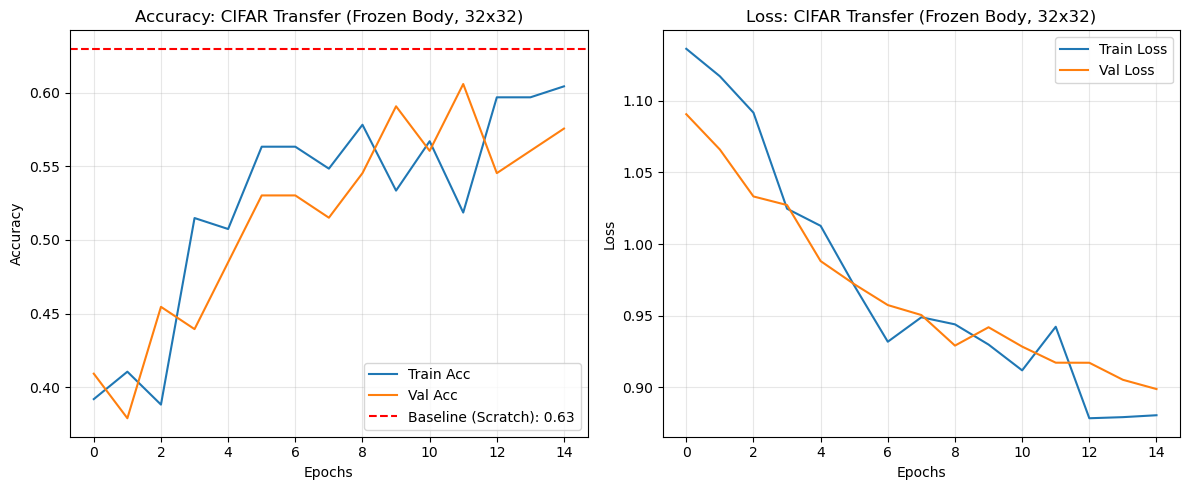

In [48]:
try:
    print("Graph 1: Transfer Learning (Frozen Body) on 32x32 Images")
    plot_transfer_results(hist_transfer_32, title="CIFAR Transfer (Frozen Body, 32x32)")
except NameError:
    print("Could not plot Frozen run (hist_transfer_32 not found). Did you run that cell?")

In [32]:
# 1. Unfreeze EVERYTHING
# We are already loaded with 32x32 data and the model is in memory.
# We just unlock the layers.
for param in model_transfer_32.parameters():
    param.requires_grad = True

print("Unfreezing All Layers for 32x32 Fine-Tuning...")

# 2. Use a Low Learning Rate 
# We use 1e-4 so we don't destroy the CIFAR weights, just nudge them.
optimizer_full_32 = optim.Adam(model_transfer_32.parameters(), lr=1e-4)

# 3. Train for 15 more epochs
print("Starting Full Fine-Tuning on 32x32 images...")

# Swap loaders again to be safe
temp_train = train_loader
temp_val = val_loader
train_loader = train_loader_32
val_loader = val_loader_32

model_transfer_32, hist_transfer_32_full = train_model(model_transfer_32, criterion, optimizer_full_32, num_epochs=15)

# Swap back
train_loader = temp_train
val_loader = temp_val

# Save
torch.save(model_transfer_32.state_dict(), 'deep_cnn_32_finetuned.pth')

Unfreezing All Layers for 32x32 Fine-Tuning...
Starting Full Fine-Tuning on 32x32 images...
Epoch 1/15
----------
train Loss: 0.8812 Acc: 0.5933
val Loss: 0.9071 Acc: 0.5455
Epoch 2/15
----------
train Loss: 0.8369 Acc: 0.6231
val Loss: 0.8775 Acc: 0.5606
Epoch 3/15
----------
train Loss: 0.8115 Acc: 0.6119
val Loss: 0.8581 Acc: 0.5758
Epoch 4/15
----------
train Loss: 0.7947 Acc: 0.6604
val Loss: 0.8509 Acc: 0.5758
Epoch 5/15
----------
train Loss: 0.7318 Acc: 0.7164
val Loss: 0.8411 Acc: 0.5909
Epoch 6/15
----------
train Loss: 0.7043 Acc: 0.7127
val Loss: 0.8278 Acc: 0.5909
Epoch 7/15
----------
train Loss: 0.6819 Acc: 0.7425
val Loss: 0.8181 Acc: 0.6061
Epoch 8/15
----------
train Loss: 0.6718 Acc: 0.7388
val Loss: 0.8131 Acc: 0.6364
Epoch 9/15
----------
train Loss: 0.6811 Acc: 0.7201
val Loss: 0.7979 Acc: 0.6515
Epoch 10/15
----------
train Loss: 0.6505 Acc: 0.7463
val Loss: 0.8004 Acc: 0.6212
Epoch 11/15
----------
train Loss: 0.6336 Acc: 0.7687
val Loss: 0.7904 Acc: 0.6212
Epoc

Graph 2: Transfer Learning (Full Fine-Tune) on 32x32 Images


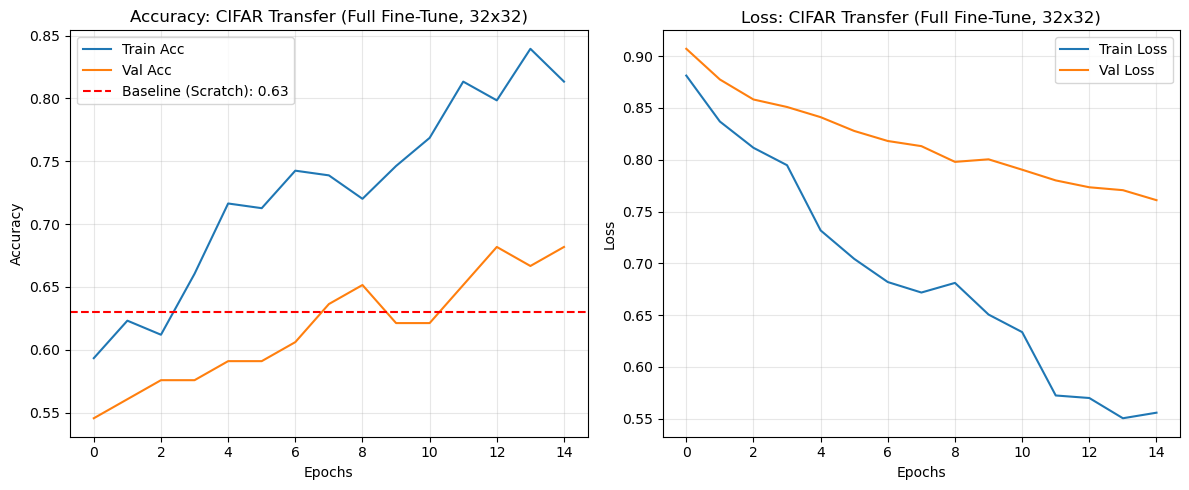

In [42]:
try:
    print("Graph 2: Transfer Learning (Full Fine-Tune) on 32x32 Images")
    plot_transfer_results(hist_transfer_32_full, title="CIFAR Transfer (Full Fine-Tune, 32x32)")
except NameError:
    print("Could not plot Fine-Tuned run (hist_transfer_32_full not found). Did you run that cell?")

Final accuracy we reached is 68%